In [ ]:
# Install the engine
!pip install gdown

In [ ]:
# Install the engine
!pip install pandas numpy matplotlib seaborn statsmodels

In [ ]:
# Install the engine
!pip install dask[dataframe]

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import FuncFormatter
import gdown
import os
import warnings
import io
import requests

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# **Reading the data**

In [ ]:
# Configuration

# --- File IDs and Constants ---
# Google Drive file IDs
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# --- Data Loading & Initial Processing ---
def make_drive_url(file_id):
    """Builds a download URL from a Google Drive file ID."""
    return f"https://drive.google.com/uc?id={file_id}"

def load_csv_from_url(url):
    """Loads a CSV from a direct URL."""
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(io.StringIO(response.text))

def download_files_from_gdrive(file_ids):
    """Downloads files from Google Drive using file IDs."""
    if not os.path.exists('temp_data_download'):
        os.makedirs('temp_data_download')

    local_paths = {}
    for key, file_id in file_ids.items():
        if file_id.startswith('YOUR_'):
            print(f"ERROR: Please update the FILE_IDS dictionary with the actual Google Drive file IDs.")
            print(f"Missing ID for: {key}")
            return None

        file_path = os.path.join('temp_data_download', f'{key}.csv')
        url = make_drive_url(file_id)
        try:
            gdown.download(url, file_path, quiet=True)
            local_paths[key] = file_path
            print(f"Downloaded {key}.csv to {file_path}")
        except Exception as e:
            print(f"Failed to download {key}.csv: {e}")
            return None
    return local_paths


download_files_from_gdrive(file_ids)

Downloaded holiday_events.csv to temp_data_download/holiday_events.csv
Downloaded items.csv to temp_data_download/items.csv
Downloaded oil.csv to temp_data_download/oil.csv
Downloaded stores.csv to temp_data_download/stores.csv
Downloaded train.csv to temp_data_download/train.csv
Downloaded transactions.csv to temp_data_download/transactions.csv


{'holiday_events': 'temp_data_download/holiday_events.csv',
 'items': 'temp_data_download/items.csv',
 'oil': 'temp_data_download/oil.csv',
 'stores': 'temp_data_download/stores.csv',
 'train': 'temp_data_download/train.csv',
 'transactions': 'temp_data_download/transactions.csv'}

In [ ]:
import dask.dataframe as dd

train.csv

Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.

The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).

Negative values of unit_sales represent returns of that particular item.

The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.

Approximately 16% of the onpromotion values in this file are NaN.

NOTE: The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and teams will need to decide the best way to handle that situation.

Also, there are a small number of items seen in the training data that aren't seen in the test data.

In [ ]:
# DASK to work with large data sets
df_train = dd.read_csv('temp_data_download/train.csv')

# Perform computations with Dask
print("--- HEAD of train ---")
display(df_train.head())
print("\n--- TAIL of train ---")
display(df_train.tail())


--- HEAD of train ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN



--- TAIL of train ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1537658,125497035,2017-08-15,54,2089339,4.0,0.0
1537659,125497036,2017-08-15,54,2106464,1.0,1.0
1537660,125497037,2017-08-15,54,2110456,192.0,0.0
1537661,125497038,2017-08-15,54,2113914,198.0,1.0
1537662,125497039,2017-08-15,54,2116416,2.0,0.0


items.csv

Item metadata, including family, class, and perishable.

NOTE: Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0.

In [ ]:
df_items = pd.read_csv('temp_data_download/items.csv')
print("--- HEAD of items ---")
display(df_items.head())
print("\n--- TAIL of items ---")
display(df_items.tail())


--- HEAD of items ---


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1



--- TAIL of items ---


,item_nbr,family,class,perishable
4095,2132318,GROCERY I,1002,0
4096,2132945,GROCERY I,1026,0
4097,2132957,GROCERY I,1068,0
4098,2134058,BEVERAGES,1124,0
4099,2134244,"LIQUOR,WINE,BEER",1364,0


holidays_events.csv

Holidays and Events, with metadata

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday.

To find the day that it was actually celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12.

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

Additional Notes

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [ ]:
df_holiday_events = pd.read_csv('temp_data_download/holiday_events.csv',)
print("--- HEAD of holiday events ---")
display(df_holiday_events .head())
print("\n--- TAIL of holiday events ---")
display(df_holiday_events .tail())

--- HEAD of holiday events ---


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False



--- TAIL of holiday events ---


,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


oil.csv

Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [ ]:
df_oil = pd.read_csv('temp_data_download/oil.csv')
print("--- HEAD of oil ---")
display(df_oil.head())
print("\n--- TAIL of oil ---")
display(df_oil.tail())

--- HEAD of oil ---


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20



--- TAIL of oil ---


,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


stores.csv

Store metadata, including city, state, type, and cluster.

cluster is a grouping of similar stores.

In [ ]:
df_stores = pd.read_csv('temp_data_download/stores.csv')
print("--- HEAD of stores ---")
display(df_stores.head())
print("\n--- TAIL of stores ---")
display(df_stores.tail())

--- HEAD of stores ---


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4



--- TAIL of stores ---


,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


transactions.csv

The count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe.

In [ ]:
df_transactions = pd.read_csv('temp_data_download/transactions.csv')
print("--- HEAD of transactions ---")
display(df_transactions.head())
print("\n--- TAIL of transactions ---")
display(df_transactions.tail())

--- HEAD of transactions ---


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922



--- TAIL of transactions ---


,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


**Data Handling: Focus on Guayas region with 2 million samples**

In [ ]:
# Load the auxiliary dataframes with pandas
dfs = {
    'stores': pd.read_csv('temp_data_download/stores.csv'),
    'items': pd.read_csv('temp_data_download/items.csv'),
    'oil': pd.read_csv('temp_data_download/oil.csv'),
    'holiday_events': pd.read_csv('temp_data_download/holiday_events.csv'),
    'transactions': pd.read_csv('temp_data_download/transactions.csv')
}

# Clean column names for all auxiliary dataframes
for key in dfs:
    dfs[key].columns = dfs[key].columns.str.strip()

# Find the store numbers for Guayas
guayas_store_ids = dfs['stores'][dfs['stores']['state'] == 'Guayas']['store_nbr'].unique()
print(f"Found {len(guayas_store_ids)} stores in Guayas")

# Load the large train data with Dask
print("Loading train.csv with Dask...")
df_train_dask = dd.read_csv('temp_data_download/train.csv')

# Clean column names in the Dask DataFrame
df_train_dask.columns = df_train_dask.columns.str.strip()

# Filter the Dask DataFrame for Guayas stores
print("Filtering Dask DataFrame for Guayas stores...")
df_train_guayas_dask = df_train_dask[df_train_dask['store_nbr'].isin(guayas_store_ids)]

# Sample the Dask DataFrame to a smaller, manageable size
sample_size = 2_000_000
if len(df_train_guayas_dask) > sample_size:
    print(f"Sampling down to {sample_size} rows...")
    df_train_guayas_dask = df_train_guayas_dask.sample(frac=sample_size / len(df_train_guayas_dask), random_state=42)

# Trigger the computation to get the final result as a pandas DataFrame
print("Triggering computation...")
df_train = df_train_guayas_dask.compute()

print(f"Train data loaded: {df_train.shape}")

Found 11 stores in Guayas
Loading train.csv with Dask...
Filtering Dask DataFrame for Guayas stores...
Sampling down to 2000000 rows...
Triggering computation...
Train data loaded: (1999999, 6)


**Missing values handling and checks**

In [ ]:
# Checked for Missing values
df_train.isna().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,347059


In [ ]:
# Focusing on missing values in the 'onpromotion' column
df_train.fillna({'onpromotion': False}, inplace=True)

In [ ]:
# Verified that the missing values have been filled
df_train.isna().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


In [ ]:
df_items.isna().sum()

,0
item_nbr,0
family,0
class,0
perishable,0


In [ ]:
df_holiday_events.isna().sum()

,0
date,0
type,0
locale,0
locale_name,0
description,0
transferred,0


In [ ]:
df_oil.isna().sum()

,0
date,0
dcoilwtico,43


In [ ]:
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')

# Verified that the missing values have been filled
df_oil.isna().sum()

,0
date,0
dcoilwtico,1


In [ ]:
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].ffill().bfill()

# Verified that the missing values have been filled
df_oil.isna().sum()

,0
date,0
dcoilwtico,0


In [ ]:
df_stores.isna().sum()

,0
store_nbr,0
city,0
state,0
type,0
cluster,0


In [ ]:
df_transactions.isna().sum()

,0
date,0
store_nbr,0
transactions,0


**Handling Outliers**

Negative sales

In [ ]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1189611,1189611,2013-01-31,24,655749,-2.0,False
877538,2781291,2013-03-10,27,1109390,-20.0,False
1553523,5327728,2013-05-08,51,119191,-5.0,False
53983,5697682,2013-05-17,24,510055,-6.0,False
1509280,7152979,2013-06-18,51,627887,-1.0,False


In [ ]:
negative_sales = (df_train['unit_sales'] < 0).sum()
print(f" Negative sales records: {negative_sales:,} ({negative_sales/len(df_train)*100:.2f}%)")

 Negative sales records: 111 (0.01%)


In [ ]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

In [ ]:
# Checking negative sales got correctly replaced
negative_sales = (df_train['unit_sales'] < 0).sum()
print(f" Negative sales records: {negative_sales:,} ({negative_sales/len(df_train)*100:.2f}%)")

 Negative sales records: 0 (0.00%)


**Extremely high sales**

In [ ]:
# Check for zero sales (outliers)
zero_sales = (df_train['unit_sales'] == 0).sum()
print(f" Zero sales entries: {zero_sales:,} ({zero_sales/len(df_train)*100:.2f}%)")

 Zero sales entries: 111 (0.01%)


In [ ]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

In [ ]:
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

In [ ]:
# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]
outliers

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
282,9192700,2013-08-03,24,105574,58.0,False,5.004094
846,37946533,2014-12-22,24,105857,111.0,0.0,7.418901
1833,40676253,2015-02-06,24,108952,25.0,0.0,5.488519
2364,96202505,2016-11-07,24,114790,42.0,1.0,7.381732
2508,5611250,2013-05-15,24,114800,159.0,False,8.868604
...,...,...,...,...,...,...,...
1995506,76901981,2016-04-20,51,2011328,32.0,0.0,5.990877
1996069,108508973,2017-03-07,51,2014085,137.0,1.0,5.315313
1996355,96741146,2016-11-12,51,2016737,68.0,1.0,5.686216
1997007,65779806,2015-12-23,51,2026631,37.0,0.0,5.492479


In [ ]:
# Replace outlier unit_sales with the value corresponding to a Z-score of 5
df_train_grouped['unit_sales'] = df_train_grouped['unit_sales'].where(df_train_grouped['z_score'] <= 5,
                                                                  (df_train_grouped.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform('mean') +
                                                                   5 * df_train_grouped.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform('std')))

**Basic Feature Engineering**

In [ ]:
# Filter for 'Guayas' state and get the unique store numbers
guayas_store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

print(f"Found {len(guayas_store_ids)} stores in Guayas")
print(guayas_store_ids)

Found 11 stores in Guayas
[24 26 27 28 29 30 32 34 35 36 51]


Top 3 families: ['GROCERY I', 'BEVERAGES', 'CLEANING']


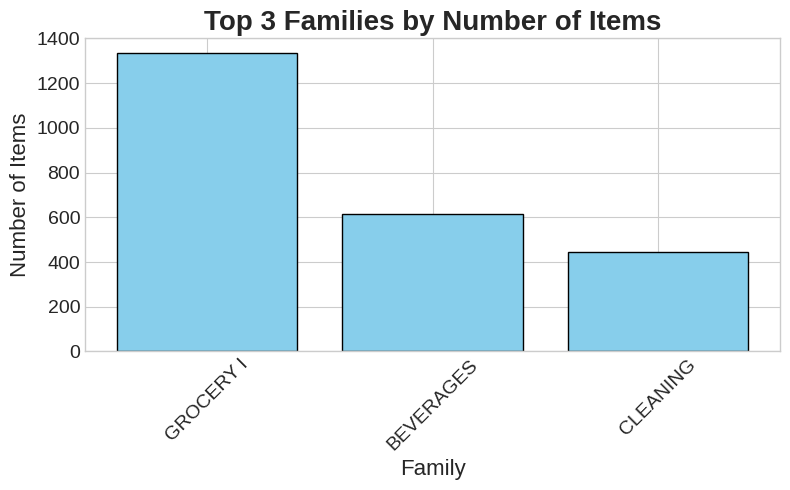

In [ ]:
# Plotting the number of items per family (for top 3 families only)
# Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families

# Actual family names for filtering
top_3_family_names = top_3_families['Family'].tolist()
print(f"Top 3 families: {top_3_family_names}")

# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

In [ ]:
# Merge with items to get families
df_train = pd.merge(df_train_grouped,df_items[['item_nbr', 'family']], on='item_nbr', how='left')

# Filter df_train to only include top 3 families
top_3_family_names = top_3_families['Family'].unique()
df_train = df_train[df_train['family'].isin(top_3_family_names)].copy()

print("First Merge complete.")

print("--- HEAD of merged dataframe ---")
display(df_train.head())
print("\n--- TAIL of merged dataframe ---")
display(df_train.tail())

First Merge complete.
--- HEAD of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family
0,302230,2013-01-09,24,96995,2.0,False,0.215699,GROCERY I
1,3580799,2013-03-29,24,96995,1.0,False,-0.718997,GROCERY I
2,2059376,2013-02-21,24,96995,1.0,False,-0.718997,GROCERY I
3,3800436,2013-04-03,24,96995,2.0,False,0.215699,GROCERY I
4,4781432,2013-04-26,24,96995,2.0,False,0.215699,GROCERY I



--- TAIL of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family
1999992,122762341,2017-07-20,51,2116416,4.0,0.0,0.707107,GROCERY I
1999993,125388723,2017-08-14,51,2122188,2.0,0.0,0.577350,GROCERY I
1999994,124770634,2017-08-08,51,2122188,1.0,0.0,-1.154701,GROCERY I
1999995,124970207,2017-08-10,51,2122188,2.0,0.0,0.577350,GROCERY I
1999996,125179467,2017-08-12,51,2123727,NaN,0.0,NaN,GROCERY I


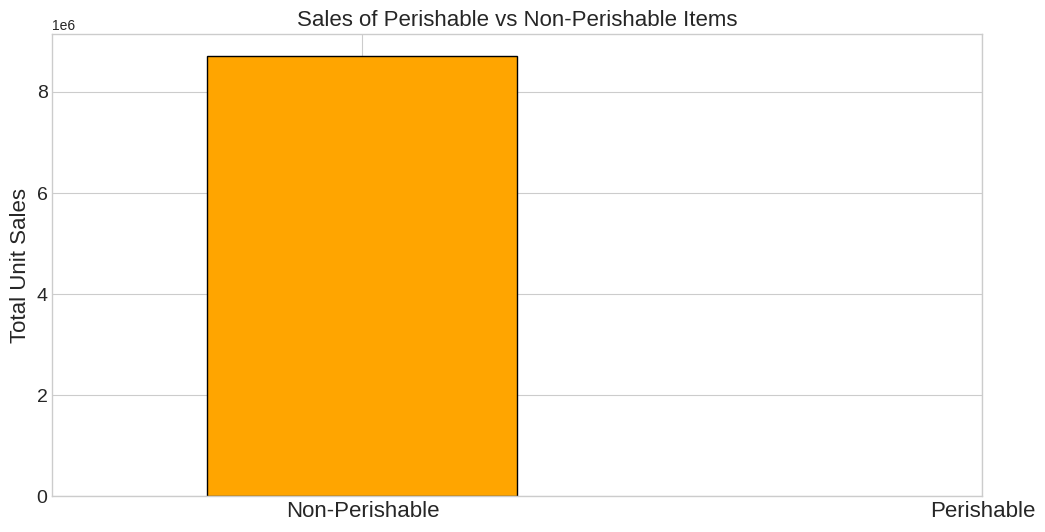

In [ ]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# Merge with stores
df_merged = pd.merge(df_train_items, dfs['stores'], on='store_nbr', how='left')

print("Second Merge complete.")

print("--- HEAD of merged dataframe ---")
display(df_merged.head())
print("\n--- TAIL of merged dataframe ---")
display(df_merged.tail())

Second Merge complete.
--- HEAD of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family_x,family_y,class,perishable,city,state,type,cluster
0,302230,2013-01-09,24,96995,2.0,False,0.215699,GROCERY I,GROCERY I,1093,False,Guayaquil,Guayas,D,1
1,3580799,2013-03-29,24,96995,1.0,False,-0.718997,GROCERY I,GROCERY I,1093,False,Guayaquil,Guayas,D,1
2,2059376,2013-02-21,24,96995,1.0,False,-0.718997,GROCERY I,GROCERY I,1093,False,Guayaquil,Guayas,D,1
3,3800436,2013-04-03,24,96995,2.0,False,0.215699,GROCERY I,GROCERY I,1093,False,Guayaquil,Guayas,D,1
4,4781432,2013-04-26,24,96995,2.0,False,0.215699,GROCERY I,GROCERY I,1093,False,Guayaquil,Guayas,D,1



--- TAIL of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family_x,family_y,class,perishable,city,state,type,cluster
1286850,122762341,2017-07-20,51,2116416,4.0,0.0,0.707107,GROCERY I,GROCERY I,1060,False,Guayaquil,Guayas,A,17
1286851,125388723,2017-08-14,51,2122188,2.0,0.0,0.577350,GROCERY I,GROCERY I,1084,False,Guayaquil,Guayas,A,17
1286852,124770634,2017-08-08,51,2122188,1.0,0.0,-1.154701,GROCERY I,GROCERY I,1084,False,Guayaquil,Guayas,A,17
1286853,124970207,2017-08-10,51,2122188,2.0,0.0,0.577350,GROCERY I,GROCERY I,1084,False,Guayaquil,Guayas,A,17
1286854,125179467,2017-08-12,51,2123727,NaN,0.0,NaN,GROCERY I,GROCERY I,1028,False,Guayaquil,Guayas,A,17


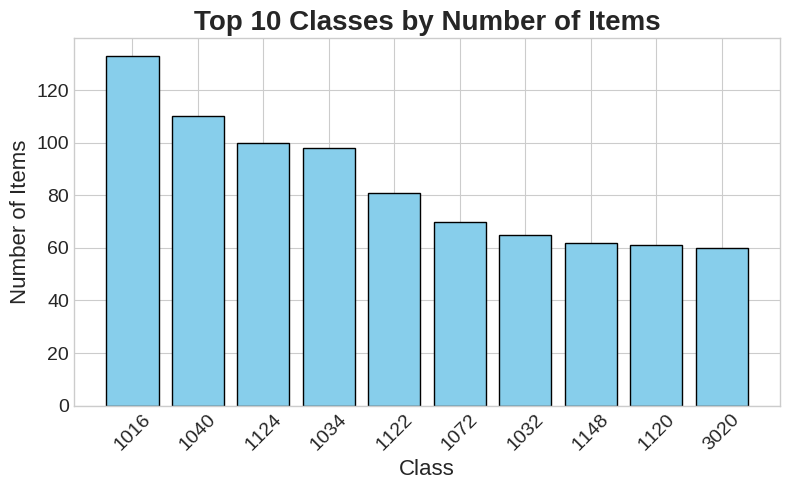

In [ ]:
# Plotting the number of items per class
# Compute the number of items per class and select the top 10 classes
items_per_class = df_items['class'].value_counts().reset_index()
items_per_class.columns = ['Class', 'Item Count']
top_10_classes = items_per_class.head(10)  # Keep only the top 10 classes

# Plot the top 10 classes
plt.figure(figsize=(8, 5))
plt.bar(top_10_classes['Class'].astype(str), top_10_classes['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 10 Classes by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Class", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

In [ ]:
# Convert date column to datetime
df_merged['date'] = pd.to_datetime(df_merged['date'])
print("Data range: from",df_merged['date'].dt.date.min(),"till",df_merged['date'].dt.date.max())

Data range: from 2013-01-02 till 2017-08-15


In [ ]:
# Creating new time-based features
df_merged['year'] = df_merged['date'].dt.year
df_merged['month'] = df_merged['date'].dt.month
df_merged['day'] = df_merged['date'].dt.day
df_merged['day_of_week'] = df_merged['date'].dt.dayofweek

In [ ]:
# Convert date column in dfs['holiday_events'] to datetime
dfs['holiday_events']['date'] = pd.to_datetime(dfs['holiday_events']['date'])

In [ ]:
# Merge with holiday events
df_merged = pd.merge(df_merged, dfs['holiday_events'], on='date', how='left')

print("Third Merge complete.")

print("--- HEAD of merged dataframe ---")
display(df_merged.head())
print("\n--- TAIL of merged dataframe ---")
display(df_merged.tail())

Third Merge complete.
--- HEAD of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family_x,family_y,class,...,cluster,year,month,day,day_of_week,type_y,locale,locale_name,description,transferred
0,302230,2013-01-09,24,96995,2.0,False,0.215699,GROCERY I,GROCERY I,1093,...,1,2013,1,9,2,NaN,NaN,NaN,NaN,NaN
1,3580799,2013-03-29,24,96995,1.0,False,-0.718997,GROCERY I,GROCERY I,1093,...,1,2013,3,29,4,NaN,NaN,NaN,NaN,NaN
2,2059376,2013-02-21,24,96995,1.0,False,-0.718997,GROCERY I,GROCERY I,1093,...,1,2013,2,21,3,NaN,NaN,NaN,NaN,NaN
3,3800436,2013-04-03,24,96995,2.0,False,0.215699,GROCERY I,GROCERY I,1093,...,1,2013,4,3,2,NaN,NaN,NaN,NaN,NaN
4,4781432,2013-04-26,24,96995,2.0,False,0.215699,GROCERY I,GROCERY I,1093,...,1,2013,4,26,4,NaN,NaN,NaN,NaN,NaN



--- TAIL of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family_x,family_y,class,...,cluster,year,month,day,day_of_week,type_y,locale,locale_name,description,transferred
1311834,122762341,2017-07-20,51,2116416,4.0,0.0,0.707107,GROCERY I,GROCERY I,1060,...,17,2017,7,20,3,NaN,NaN,NaN,NaN,NaN
1311835,125388723,2017-08-14,51,2122188,2.0,0.0,0.577350,GROCERY I,GROCERY I,1084,...,17,2017,8,14,0,NaN,NaN,NaN,NaN,NaN
1311836,124770634,2017-08-08,51,2122188,1.0,0.0,-1.154701,GROCERY I,GROCERY I,1084,...,17,2017,8,8,1,NaN,NaN,NaN,NaN,NaN
1311837,124970207,2017-08-10,51,2122188,2.0,0.0,0.577350,GROCERY I,GROCERY I,1084,...,17,2017,8,10,3,Holiday,National,Ecuador,Primer Grito de Independencia,True
1311838,125179467,2017-08-12,51,2123727,NaN,0.0,NaN,GROCERY I,GROCERY I,1028,...,17,2017,8,12,5,NaN,NaN,NaN,NaN,NaN


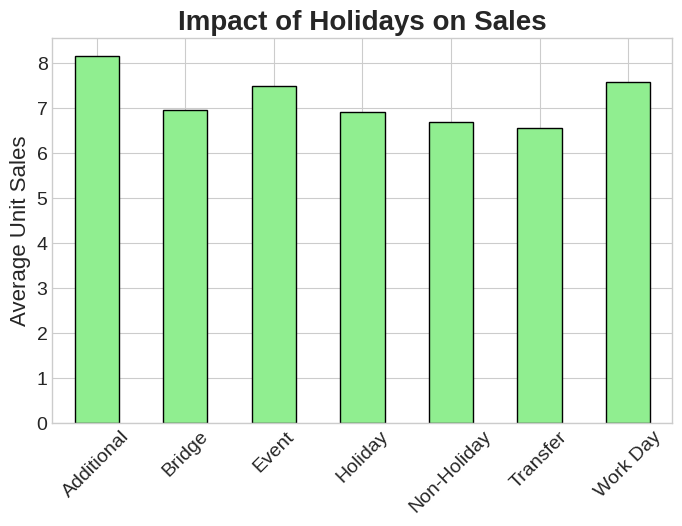

In [ ]:
# Aggregating sales by holiday and non-holiday
# Fill the NaN values in type_y with 'Non-Holiday'
df_merged['type_y'] = df_merged['type_y'].fillna('Non-Holiday')

# Now, group by the correct column 'type_y'
holiday_sales = df_merged.groupby('type_y')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# Convert date column in dfs['oil'] to datetime
dfs['oil']['date'] = pd.to_datetime(dfs['oil']['date'])

In [ ]:
# Merge with oil
df_merged = pd.merge(df_merged, dfs['oil'], on='date', how='left')

print("Fourth Merge complete.")

print("--- HEAD of merged dataframe ---")
display(df_merged.head())
print("\n--- TAIL of merged dataframe ---")
display(df_merged.tail())

Fourth Merge complete.
--- HEAD of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family_x,family_y,class,...,year,month,day,day_of_week,type_y,locale,locale_name,description,transferred,dcoilwtico
0,302230,2013-01-09,24,96995,2.0,False,0.215699,GROCERY I,GROCERY I,1093,...,2013,1,9,2,Non-Holiday,NaN,NaN,NaN,NaN,93.08
1,3580799,2013-03-29,24,96995,1.0,False,-0.718997,GROCERY I,GROCERY I,1093,...,2013,3,29,4,Non-Holiday,NaN,NaN,NaN,NaN,NaN
2,2059376,2013-02-21,24,96995,1.0,False,-0.718997,GROCERY I,GROCERY I,1093,...,2013,2,21,3,Non-Holiday,NaN,NaN,NaN,NaN,92.79
3,3800436,2013-04-03,24,96995,2.0,False,0.215699,GROCERY I,GROCERY I,1093,...,2013,4,3,2,Non-Holiday,NaN,NaN,NaN,NaN,95.02
4,4781432,2013-04-26,24,96995,2.0,False,0.215699,GROCERY I,GROCERY I,1093,...,2013,4,26,4,Non-Holiday,NaN,NaN,NaN,NaN,92.63



--- TAIL of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family_x,family_y,class,...,year,month,day,day_of_week,type_y,locale,locale_name,description,transferred,dcoilwtico
1311834,122762341,2017-07-20,51,2116416,4.0,0.0,0.707107,GROCERY I,GROCERY I,1060,...,2017,7,20,3,Non-Holiday,NaN,NaN,NaN,NaN,46.73
1311835,125388723,2017-08-14,51,2122188,2.0,0.0,0.577350,GROCERY I,GROCERY I,1084,...,2017,8,14,0,Non-Holiday,NaN,NaN,NaN,NaN,47.59
1311836,124770634,2017-08-08,51,2122188,1.0,0.0,-1.154701,GROCERY I,GROCERY I,1084,...,2017,8,8,1,Non-Holiday,NaN,NaN,NaN,NaN,49.07
1311837,124970207,2017-08-10,51,2122188,2.0,0.0,0.577350,GROCERY I,GROCERY I,1084,...,2017,8,10,3,Holiday,National,Ecuador,Primer Grito de Independencia,True,48.54
1311838,125179467,2017-08-12,51,2123727,NaN,0.0,NaN,GROCERY I,GROCERY I,1028,...,2017,8,12,5,Non-Holiday,NaN,NaN,NaN,NaN,NaN


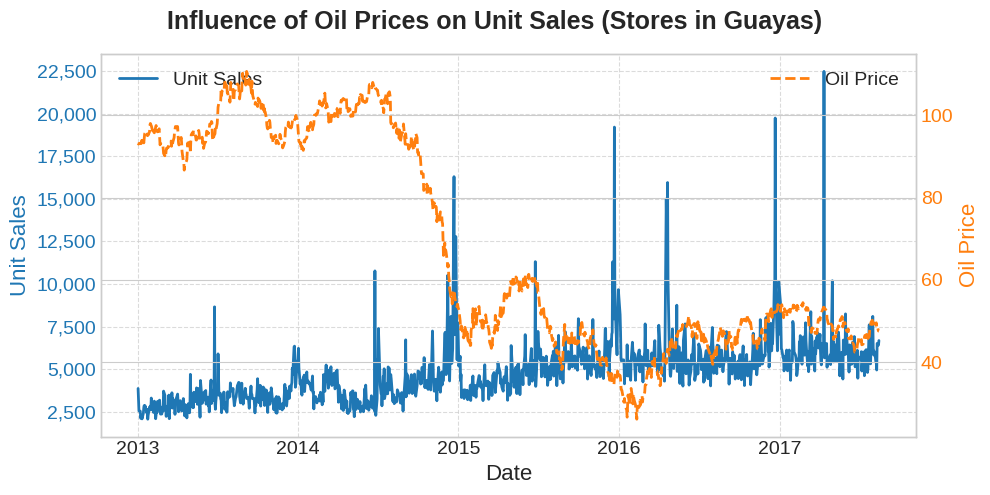

In [ ]:
# Aggregate sales data by date (using 'unit_sales')
sales_by_date = df_merged.groupby('date')['unit_sales'].sum().reset_index()

# Extract the oil prices by date from merged dataframe
oil_prices_by_date = df_merged[['date', 'dcoilwtico']].drop_duplicates().reset_index(drop=True)

# Merge aggregated sales with oil prices
merged_data = pd.merge(sales_by_date, oil_prices_by_date, on='date', how='left')

# Drop rows where oil price is NaN
merged_data = merged_data.dropna(subset=['dcoilwtico'])

# Plot unit sales and oil prices
fig, ax1 = plt.subplots(figsize=(10, 5))  # Bigger figure size for better readability

# Plot unit sales on the left y-axis
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Unit Sales', fontsize=16, color='tab:blue')
ax1.plot(merged_data['date'], merged_data['unit_sales'], label='Unit Sales', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Format y-axis for unit sales to show thousands with commas
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Plot oil prices on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price', fontsize=16, color='tab:orange')
ax2.plot(merged_data['date'], merged_data['dcoilwtico'], label='Oil Price', color='tab:orange', linewidth=2, linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)

# Add grid, titles, and legends
fig.suptitle('Influence of Oil Prices on Unit Sales (Stores in Guayas)', fontsize=18, fontweight='bold')
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper right', fontsize=14)
ax1.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from overlapping
plt.tight_layout()
plt.show()

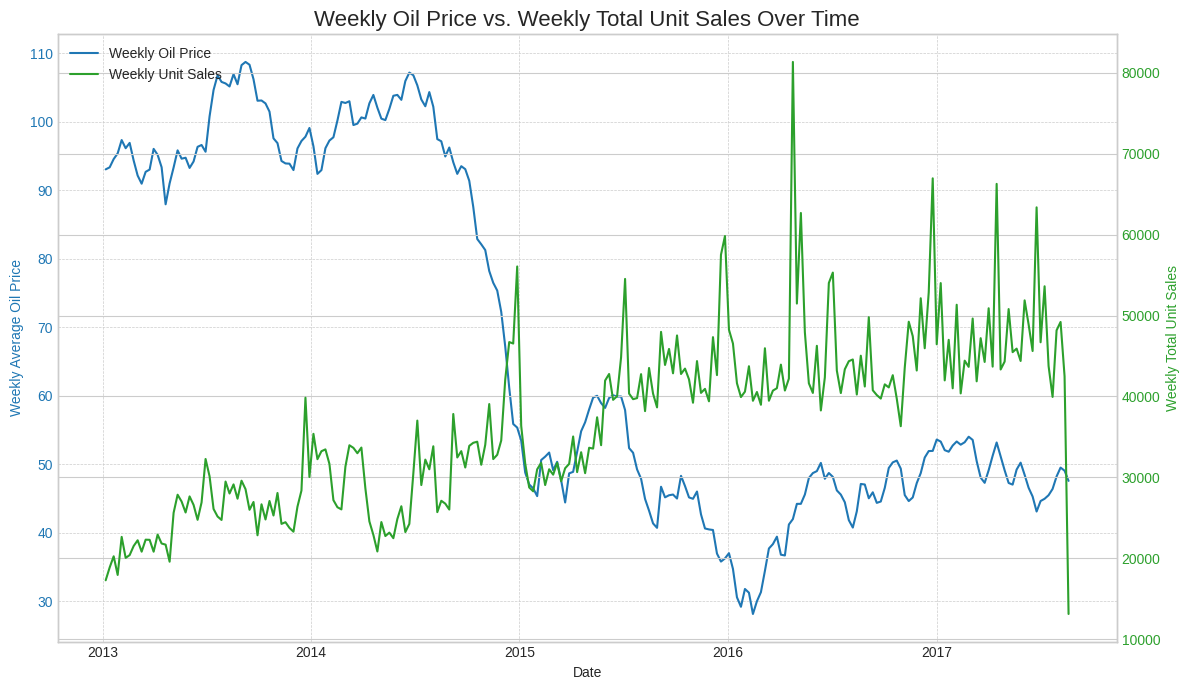

In [ ]:
# Aggregate data by week to reduce the number of points for plotting
# Resample on 'date' column with 'W' for weekly frequency
df_weekly = df_merged.set_index('date').resample('W').agg({
    'unit_sales': 'sum',
    'dcoilwtico': 'mean'  # Take the mean for oil price
}).reset_index()

# Plotting weekly oil price vs weekly unit sales
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Average Oil Price', color='tab:blue')
ax1.plot(df_weekly['date'], df_weekly['dcoilwtico'], color='tab:blue', label='Weekly Oil Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel('Weekly Total Unit Sales', color='tab:green')
ax2.plot(df_weekly['date'], df_weekly['unit_sales'], color='tab:green', label='Weekly Unit Sales')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Adding a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Weekly Oil Price vs. Weekly Total Unit Sales Over Time', fontsize=16)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

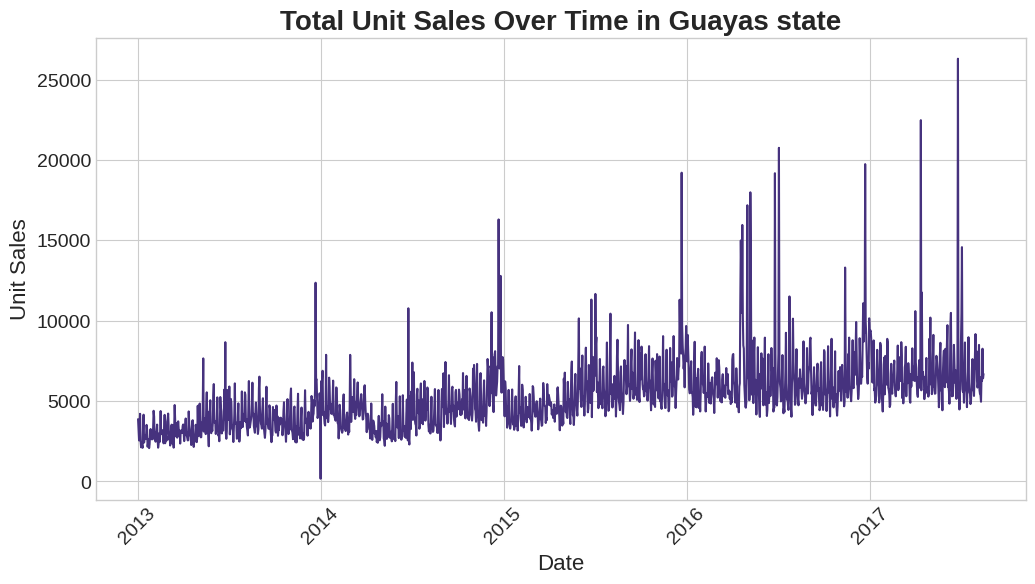

In [ ]:
# Aggregating total sales by date
sales_by_date = df_merged.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# Make sure 'date' is a real datetime
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Split the timestamp into model-friendly parts
df_merged['year'] = df_merged['date'].dt.year
df_merged['month'] = df_merged['date'].dt.month
df_merged['day'] = df_merged['date'].dt.day
df_merged['day_of_week'] = df_merged['date'].dt.dayofweek # Monday=0 … Sunday=6

# Lets check the result
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family
0,302230,2013-01-09,24,96995,2.0,False,0.215699,GROCERY I
1,3580799,2013-03-29,24,96995,1.0,False,-0.718997,GROCERY I
2,2059376,2013-02-21,24,96995,1.0,False,-0.718997,GROCERY I
3,3800436,2013-04-03,24,96995,2.0,False,0.215699,GROCERY I
4,4781432,2013-04-26,24,96995,2.0,False,0.215699,GROCERY I


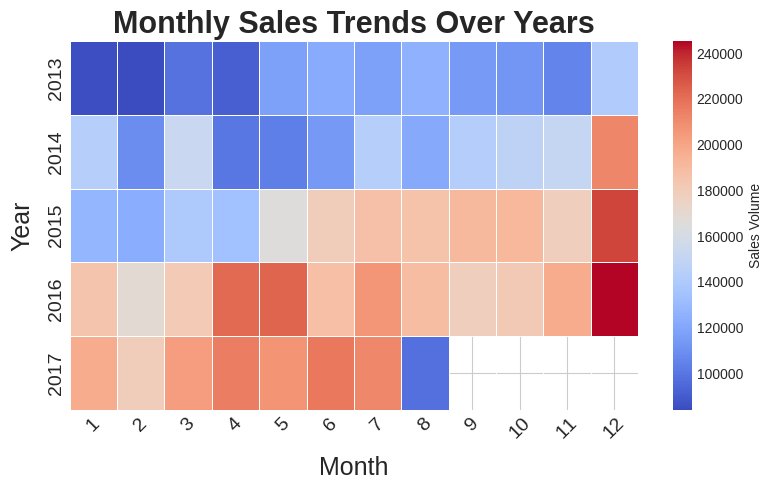

In [ ]:
# Aggregating sales by year and month
sales_by_month = df_merged.groupby(['year', 'month'])['unit_sales'].sum().unstack()
# Plotting heatmap of sales by year and month
import seaborn as sns

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

In [ ]:
# Make sure the date column is a real datetime
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Aggregate duplicates first

df_merged_agg = df_merged.groupby(
    ['date', 'store_nbr', 'item_nbr']
).sum().reset_index()

In [ ]:
def fill_calendar(group):
    # group contains all rows for ONE (store_nbr, item_nbr) pair
    g = group.set_index("date").sort_index()
    g = g.asfreq("D", fill_value=0)

    # put the identifiers back (asfreq drops them)
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"] = group["item_nbr"].iloc[0]

    return g.reset_index()

df_merged = (
    df_merged_agg  # Use the new aggregated DataFrame
    .groupby(["store_nbr", "item_nbr"], group_keys=False)
    .apply(fill_calendar)
)

df_merged.head()

,date,store_nbr,item_nbr,id,unit_sales,onpromotion,z_score,family_x,family_y,class,...,year,month,day,day_of_week,type_y,locale,locale_name,description,transferred,dcoilwtico
0,2013-01-09,24,96995,302230,2.0,False,0.215699,GROCERY I,GROCERY I,1093,...,2013,1,9,2,Non-Holiday,0,0,0,0,93.08
1,2013-01-10,24,96995,0,0.0,0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
2,2013-01-11,24,96995,0,0.0,0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
3,2013-01-12,24,96995,0,0.0,0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
4,2013-01-13,24,96995,0,0.0,0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00


In [ ]:
df_merged.columns

Index(['date', 'store_nbr', 'item_nbr', 'id', 'unit_sales', 'onpromotion',
       'z_score', 'family_x', 'family_y', 'class', 'perishable', 'city',
       'state', 'type_x', 'cluster', 'year', 'month', 'day', 'day_of_week',
       'type_y', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico'],
      dtype='object')

In [ ]:
df_merged.isna().sum()

,0
date,0
store_nbr,0
item_nbr,0
id,0
unit_sales,0
onpromotion,0
z_score,0
family_x,0
family_y,0
class,0


In [ ]:
# To save as a CSV file
df_merged.to_csv('df_merged.csv', index=False)

In [ ]:
# To save as a Pickle file
df_merged.to_pickle('df_merged.pkl')

NameError: name 'df_merged' is not defined

In [ ]:
# Install engine
!pip install pyarrow

# Convert 'onpromotion' column to boolean
df_merged['onpromotion'] = df_merged['onpromotion'].astype(bool)

# To save as a Parquet file
df_merged.to_parquet('df_merged.parquet', engine='pyarrow', index=False)

RAM issues, did second step for Week 1 in another notebook.

df_merged was renamed df_merged_uno and worked on in : https://colab.research.google.com/drive/1tybOi5MJTlTjOtog5MkPC0Y32a3gqRWv?usp=sharing